<a href="https://colab.research.google.com/github/DobakDavid/portfolio/blob/main/TinyVGG_EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project: Small VGGNet-like CNN architecture (TinyVGG) for EMNIST classification
In this script I am creating a CNN for the classification of EMNIST dataset. The CNN is a small VGGNet-like architecture. The dataset consists of images of handwritten characters. This code can be used as a template for further projects.

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

# Import matplotlib
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import tqdm
from tqdm.auto import tqdm

# Measure time
from timeit import default_timer as timer

### 0. Steup device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1. Preparing data

In [ ]:
# Import the EMNIST dataset for train data and test data
train_data = datasets.EMNIST(
    root="data",
    split ="letters",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.EMNIST(
    root="data",
    split = "letters",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
# Turn data into batches/mini batches
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

# Observation of batch numbers
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b934485a1a0>, <torch.utils.data.dataloader.DataLoader object at 0x7b934485ae00>)
Length of train dataloader: 3900 batches of 32
Length of test dataloader: 650 batches of 32


### 2. Defining the models

In [ ]:
# Define V0 class - baseline model, without nonlinearity
from torch import nn
class EMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

# Define V1 class - Concolutional Neural Network (CNN)
class EMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),

        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),

        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


In [ ]:
# Creating instances of the model classes

torch.manual_seed(42)

class_names = train_data.classes

model_0 = EMNISTModelV0(
    input_shape = 28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_1 = EMNISTModelV1(
    input_shape = 1,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_0, model_1

(EMNISTModelV0(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=27, bias=True)
   )
 ),
 EMNISTModelV1(
   (conv_block_1): Sequential(
     (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=490, out_features=27, bias=True)
   )
 ))

### 3. Setup loss, optimizer and evaluatioan metrics, timers

In [ ]:
from urllib import request
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.1)

helper_functions.py already exists, skipping download


### 3. Define `train` using `train_step` and `test_step`

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  """ Functionizing training loop. """

  # Initialize training loss and training accuracy
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):

    # 0. Sending the data to device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss: .5f} | Train acc: {train_acc:.2f}")

  return train_loss.item(), train_acc

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
  """ Functionizing test loop. """

  # Initialize test loss and training accuracy
  test_loss, test_acc = 0, 0
  model.eval()

  # Put model into inference mode
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      # 0. Sending the data to device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      test_pred = model(X_test)

      # 2. Calculate the loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))

    # Divide total test loss by length of test dataloader
    test_loss /= len(test_dataloader)

    # Calculate the test acc average
    test_acc /= len(test_dataloader)

  # Return the results
  return test_loss.item(), test_acc

# Combine train_step and test_step in one function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 1. Create empty results dictionary
  results = {"model_name": [model.__class__.__name__],
             "train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  # 2. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       accuracy_fn = accuracy_fn,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn,
                                    device = device)

    # 3. Print out the values
    print(f"Epoch: {epoch + 1} | "
          f"train_loss: {train_loss: .4f} | "
          f"train_acc: {train_acc: .4f} | "
          f"test_loss: {test_loss: .4f} | "
          f"test_acc: {test_acc: .4f}"
          )

    # 4. Update the results dictionary
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  # Return the results at the end of the epochs
  return results


## 4. Training and testing of the models

### 4.1 V0 model

In [ ]:
# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Hyperparameters
LEARNING_RATE = 0.1 # Learning rate
NUM_EPOCHS = 3 # Number of epochs

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = LEARNING_RATE)

train_time_start_model_0 = timer() # Beginning of time measure
# Execute train function
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        accuracy_fn = accuracy_fn,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
train_time_end_model_0 = timer() # End of time measure

# Total train time
total_train_time_model_0 = train_time_end_model_0 - train_time_start_model_0

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss:  1.35836 | Train acc: 60.44
Epoch: 1 | train_loss:  1.3584 | train_acc:  60.4439 | test_loss:  1.2738 | test_acc:  63.3990
Train loss:  1.24101 | Train acc: 63.86
Epoch: 2 | train_loss:  1.2410 | train_acc:  63.8574 | test_loss:  1.2607 | test_acc:  62.1587
Train loss:  1.23172 | Train acc: 64.02
Epoch: 3 | train_loss:  1.2317 | train_acc:  64.0216 | test_loss:  1.2248 | test_acc:  64.3990


## 4.2 V1 model

In [ ]:
# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Hyperparameters
LEARNING_RATE = 0.1 # Learning rate
NUM_EPOCHS = 5

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr=LEARNING_RATE)

train_time_start_model_1 = timer() # Beginning of time measure
# Execute train function
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        accuracy_fn = accuracy_fn,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
train_time_end_model_1 = timer() # End of time measure

# Total train time
total_train_time_model_1 = train_time_end_model_1 - train_time_start_model_1

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss:  0.56073 | Train acc: 82.85
Epoch: 1 | train_loss:  0.5607 | train_acc:  82.8470 | test_loss:  0.3616 | test_acc:  88.7596
Train loss:  0.31541 | Train acc: 89.99
Epoch: 2 | train_loss:  0.3154 | train_acc:  89.9928 | test_loss:  0.3060 | test_acc:  90.4038
Train loss:  0.27860 | Train acc: 90.97
Epoch: 3 | train_loss:  0.2786 | train_acc:  90.9728 | test_loss:  0.2809 | test_acc:  91.1202
Train loss:  0.26001 | Train acc: 91.56
Epoch: 4 | train_loss:  0.2600 | train_acc:  91.5577 | test_loss:  0.2705 | test_acc:  91.4231
Train loss:  0.24769 | Train acc: 91.90
Epoch: 5 | train_loss:  0.2477 | train_acc:  91.9046 | test_loss:  0.2763 | test_acc:  91.2885


## 5. Comparison of the results

In [ ]:
# Import pandas
import pandas as pd
compare_results = pd.DataFrame([{key: value[-1] for key, value in model_0_results.items()},
                                {key: value[-1] for key, value in model_1_results.items()}])
# Adding training time coloumn
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1]
compare_results


,model_name,train_loss,train_acc,test_loss,test_acc,training_time
0,EMNISTModelV0,1.231724,64.021635,1.224785,64.399038,73.512516
1,EMNISTModelV1,0.247686,91.904647,0.276276,91.288462,607.512748


## 6. Prediction with visualization

### 6.1 Define `make_predictions`

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare sample
      sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send to device

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      # Get pred_prob off from device to cpu
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

## 6.2 Visualize predictions

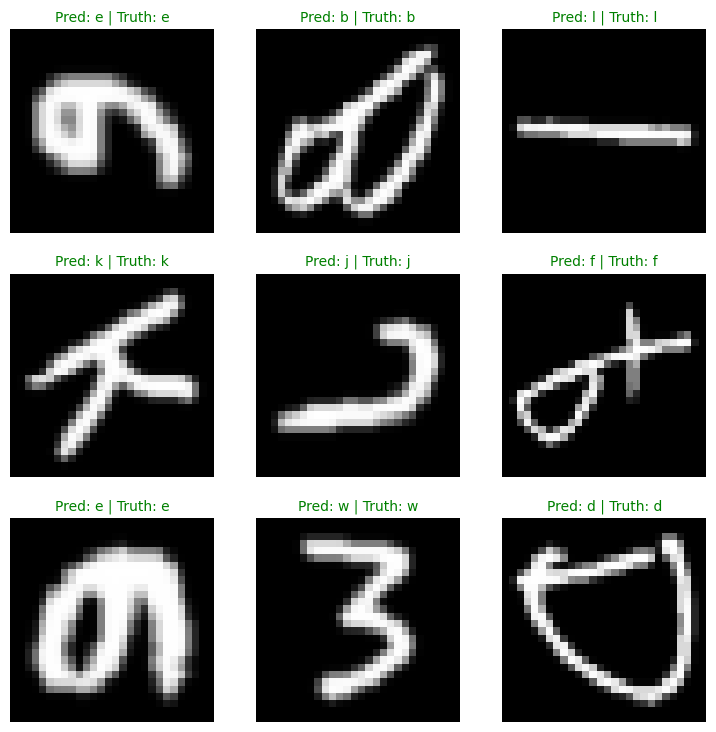

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# Make predictions on test samples with model 1
pred_probs= make_predictions(model=model_1,
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## 7. Creating a consfusion matrix

In [ ]:
# 1. Make predictions with trained model
y_preds = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/650 [00:00<?, ?it/s]

In [ ]:
# If torchmetrics not exists, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install torchmetrics
    print(f"mlxtend version: {mlxtend.__version__}")

# Imports from torchmetrics and mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

mlxtend version: 0.23.2


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


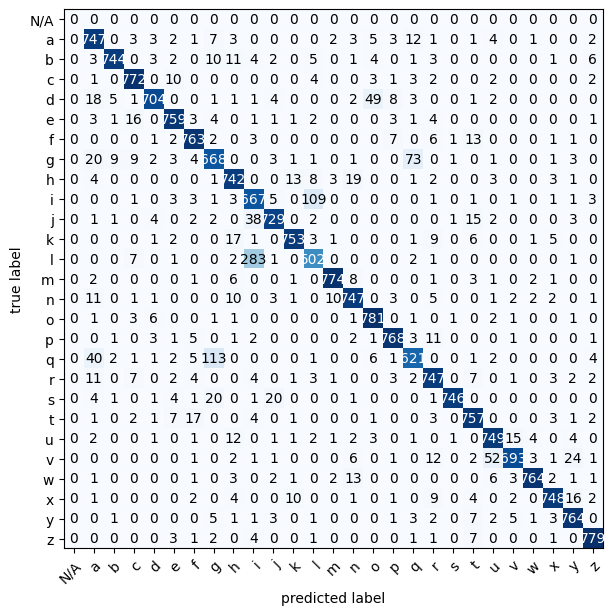

In [ ]:
# 1. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 2. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

Observations: <br>
- Visible confusion between `i` and `l`
- Slightly smaller confusion between `g` and `q`<br>
Both are understandable because of the similarities between the characters

## 8. Save the best model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "EMNIST_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/EMNIST_model_1.pth
